In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import fitsio as ft
import sys
import logging
import healpy as hp

sys.path.append('/home/mehdi/github/LSSutils')
import LSSutils.lab as lb
from LSSutils import setup_logging
setup_logging('info')

camb is not installed!


In [94]:
zmin = 0.8
zmax = 2.2
data = lb.EbossCatalog('/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_0009.dat.fits', 
                      zmin=zmin, zmax=zmax)

random = lb.EbossCatalog('/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_0009.ran.fits', 
                      zmin=zmin, zmax=zmax, kind='random')

[ 002864.85 ]   0: 04-17 14:42  EbossCatalog    INFO     compmin : 0.5
[ 002864.85 ]   0: 04-17 14:42  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 002864.86 ]   0: 04-17 14:42  EbossCatalog    INFO     219550 galaxies pass the cuts
[ 002864.86 ]   0: 04-17 14:42  EbossCatalog    INFO     % of galaxies after cut 1.00
[ 002864.99 ]   0: 04-17 14:42  EbossCatalog    INFO     compmin : 0.5
[ 002864.99 ]   0: 04-17 14:42  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 002865.12 ]   0: 04-17 14:42  EbossCatalog    INFO     3961799 randoms pass the cuts
[ 002865.13 ]   0: 04-17 14:42  EbossCatalog    INFO     % of randoms after cut 1.00


In [5]:
r_default = lb.power(data.data, random.data, poles=[0], dk=0.005)

data    columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
randoms columns =  ['COMP_BOSS', 'DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z', 'sector_SSR']
including sys_tot


[ 000020.31 ]   0: 04-17 13:55  FKPCatalog      INFO     cartesian coordinate range: [-3290.89299958 -3209.40942239   536.34511885] : [-191.57287176 3295.69789273 3276.7464279 ]
[ 000020.31 ]   0: 04-17 13:55  FKPCatalog      INFO     BoxSize = [3162. 6636. 2796.]
[ 000020.31 ]   0: 04-17 13:55  FKPCatalog      INFO     BoxCenter = [-1741.23293567    43.14423517  1906.54577338]
[ 000020.32 ]   0: 04-17 13:55  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'
[ 000020.32 ]   0: 04-17 13:55  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'
[ 000022.68 ]   0: 04-17 13:55  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 219550 
[ 000023.10 ]   0: 04-17 13:55  CatalogMesh     INFO     painted 219550 out of 219550 objects to mesh
[ 000023.16 ]   0: 04-17 13:55  CatalogMesh     INFO     painted 219550 out of 219550 objects to mesh
[ 000023.16 ]   0: 04-17 13:55  CatalogMesh     INFO     mean particles

In [25]:
class SysWeight(object):
    '''
    Reads the systematic weights in healpix
    Assigns them to a set of RA and DEC (both in degrees)

    ex:
        > Mapper = SysWeight('nn-weights.hp256.fits')
        > wsys = Mapper(ra, dec)    
    '''
    logger = logging.getLogger('SysWeight')
    
    def __init__(self, filename, ismap=False, fix=False, clip=False):
        if ismap:
            self.wmap  = filename
        else:
            self.wmap  = hp.read_map(filename, verbose=False)
            
        self.nside = hp.get_nside(self.wmap)
        self.fix = fix
        self.clip = clip

    def __call__(self, ra, dec):
        
        
        hpix = lb.radec2hpix(self.nside, ra, dec) # HEALPix index from RA and DEC
        wsys = self.wmap[hpix]                 # Selection mask at the pixel
        
        if self.fix:
            
            NaNs = np.isnan(wsys)                  # check if there is any NaNs
            self.logger.info(f'# NaNs : {NaNs.sum()}')

            NaNs |= (wsys <= 0.0)                  # negative weights
            if self.clip:
                self.logger.info('< or > 2x')
                
                NaNs |= (wsys < 0.5) 
                NaNs |= (wsys > 2.0)
                
            self.logger.info(f'# NaNs or lt 0: {NaNs.sum()}')


            if NaNs.sum() !=0:

                nan_wsys = np.argwhere(NaNs).flatten()
                nan_hpix = hpix[nan_wsys]

                # use the average of the neighbors
                self.logger.info(f'# NaNs (before) : {len(nan_hpix)}')
                neighbors = hp.get_all_neighbours(self.nside, nan_hpix) 
                wsys[nan_wsys] = np.nanmean(self.wmap[neighbors], axis=0)

                # 
                NNaNs  = np.isnan(wsys).sum()
                self.logger.info(f'# NaNs (after)  : {NNaNs}')

            
            
        assert np.all(wsys > 0.0),f'{(wsys <= 0.0).sum()} weights <= 0.0!' 
        
        return 1./wsys # Systematic weight = 1 / Selection mask

In [103]:
path = '/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/results/'
zcuts = {
       'low':[[0.8, 1.5], SysWeight(f'{path}NGC_low_512/regression/nn_plain/nn-weights.hp512.fits', fix=False)],
       'high':[[1.5, 2.2], SysWeight(f'{path}NGC_high_512/regression/nn_plain/nn-weights.hp512.fits', fix=False)]
       }
data.swap(zcuts, ['low', 'high'])

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
[ 003341.84 ]   0: 04-17 14:50  EbossCatalog    INFO     slice: low, wsysmin: nan, wsysmax: nan
[ 003341.85 ]   0: 04-17 14:50  EbossCatalog    INFO     number of objs w zcut [0.8, 1.5] : 108489
[ 003341.86 ]   0: 04-17 14:50  EbossCatalog    INFO     slice: high, wsysmin: nan, wsysmax: nan
[ 003341.86 ]   0: 04-17 14:50  EbossCatalog    INFO     number of objs w zcut [1.5, 2.2] : 111061


In [104]:
finite = np.isfinite(data.data['WEIGHT_SYSTOT'])
print(finite.mean())
finite &= (data.data['WEIGHT_SYSTOT']>0.5) & (data.data['WEIGHT_SYSTOT'] < 2.0)
print(finite.mean(), finite.sum(), finite.size)

0.9996675017080392
0.999653837394671 219474 219550


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [96]:
finite = np.isfinite(data.data['WEIGHT_SYSTOT'])
print(finite.mean())
finite &= (data.data['WEIGHT_SYSTOT']>0.5) & (data.data['WEIGHT_SYSTOT'] < 2.0)
print(finite.mean())
data.datacut = data.data[finite]
random_cut = random.reassign(source=data.datacut)
r_cut = lb.power(data.datacut, random_cut, poles=[0], dk=0.005)

0.9996675017080392
0.999653837394671


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


data    columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
randoms columns =  ['COMP_BOSS', 'DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z', 'sector_SSR']
including sys_tot


[ 002882.48 ]   0: 04-17 14:43  FKPCatalog      INFO     cartesian coordinate range: [-3298.59016166 -3226.67921935   540.6583823 ] : [-193.21855437 3297.15241018 3276.92883478]
[ 002882.48 ]   0: 04-17 14:43  FKPCatalog      INFO     BoxSize = [3168. 6655. 2791.]
[ 002882.48 ]   0: 04-17 14:43  FKPCatalog      INFO     BoxCenter = [-1745.90435802    35.23659542  1908.79360854]
[ 002882.49 ]   0: 04-17 14:43  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'
[ 002882.49 ]   0: 04-17 14:43  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'
[ 002885.30 ]   0: 04-17 14:43  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 219474 
[ 002886.85 ]   0: 04-17 14:43  CatalogMesh     INFO     painted 219474 out of 219474 objects to mesh
[ 002887.02 ]   0: 04-17 14:43  CatalogMesh     INFO     painted 219474 out of 219474 objects to mesh
[ 002887.03 ]   0: 04-17 14:43  CatalogMesh     INFO     mean particles

In [10]:
finite = np.isfinite(data.data['WEIGHT_SYSTOT'])
print(finite.mean())
finite &= (data.data['WEIGHT_SYSTOT'] > 0.5) & (data.data['WEIGHT_SYSTOT'] < 2.0)
print(finite.mean())
data.datafill = data.data.copy()
data.datafill['WEIGHT_SYSTOT'][~finite] = 1.0

random_fill = random.reassign(source=data.datafill)
r_fill = lb.power(data.datafill, random_fill, poles=[0], dk=0.005)

0.9996675017080392
0.999653837394671


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


data    columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
randoms columns =  ['COMP_BOSS', 'DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z', 'sector_SSR']
including sys_tot


[ 000322.46 ]   0: 04-17 14:00  FKPCatalog      INFO     cartesian coordinate range: [-3298.93746943 -3225.67251941   536.7644628 ] : [-193.6232622  3297.12602672 3276.39360506]
[ 000322.46 ]   0: 04-17 14:00  FKPCatalog      INFO     BoxSize = [3168. 6654. 2795.]
[ 000322.46 ]   0: 04-17 14:00  FKPCatalog      INFO     BoxCenter = [-1746.28036582    35.72675366  1906.57903393]
[ 000322.49 ]   0: 04-17 14:00  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'
[ 000322.49 ]   0: 04-17 14:00  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'
[ 000325.09 ]   0: 04-17 14:00  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 219550 
[ 000325.58 ]   0: 04-17 14:00  CatalogMesh     INFO     painted 219550 out of 219550 objects to mesh
[ 000325.65 ]   0: 04-17 14:00  CatalogMesh     INFO     painted 219550 out of 219550 objects to mesh
[ 000325.65 ]   0: 04-17 14:00  CatalogMesh     INFO     mean particles

In [102]:
(~finite).sum()

76

In [11]:
zmin = 0.8
zmax = 2.2
data_null = lb.EbossCatalog('/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0009.dat.fits', 
                      zmin=zmin, zmax=zmax)

random_null = lb.EbossCatalog('/B/Shared/eBOSS/null/EZmock_eBOSS_QSO_NGC_v7_noweight_0009.ran.fits', 
                      zmin=0.8, zmax=2.2, kind='random')

[ 000389.80 ]   0: 04-17 14:01  EbossCatalog    INFO     compmin : 0.5
[ 000389.80 ]   0: 04-17 14:01  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 000389.81 ]   0: 04-17 14:01  EbossCatalog    INFO     232002 galaxies pass the cuts
[ 000389.81 ]   0: 04-17 14:01  EbossCatalog    INFO     % of galaxies after cut 1.00
[ 000389.93 ]   0: 04-17 14:01  EbossCatalog    INFO     compmin : 0.5
[ 000389.93 ]   0: 04-17 14:01  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 000390.07 ]   0: 04-17 14:01  EbossCatalog    INFO     3561773 randoms pass the cuts
[ 000390.08 ]   0: 04-17 14:01  EbossCatalog    INFO     % of randoms after cut 1.00


In [12]:
r_null = lb.power(data_null.data, random_null.data, poles=[0], dk=0.005)

data    columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
randoms columns =  ['COMP_BOSS', 'DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z', 'sector_SSR']
including sys_tot


[ 000408.79 ]   0: 04-17 14:01  FKPCatalog      INFO     cartesian coordinate range: [-3296.69934474 -3220.91259213   537.24547698] : [-192.05109959 3299.40275275 3276.11714144]
[ 000408.80 ]   0: 04-17 14:01  FKPCatalog      INFO     BoxSize = [3167. 6651. 2794.]
[ 000408.80 ]   0: 04-17 14:01  FKPCatalog      INFO     BoxCenter = [-1744.37522216    39.24508031  1906.68130921]
[ 000408.81 ]   0: 04-17 14:01  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'
[ 000408.81 ]   0: 04-17 14:01  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'
[ 000410.89 ]   0: 04-17 14:01  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 232002 
[ 000411.41 ]   0: 04-17 14:01  CatalogMesh     INFO     painted 232002 out of 232002 objects to mesh
[ 000411.48 ]   0: 04-17 14:01  CatalogMesh     INFO     painted 232002 out of 232002 objects to mesh
[ 000411.48 ]   0: 04-17 14:01  CatalogMesh     INFO     mean particles

In [14]:
data = lb.EbossCatalog('/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_0009.dat.fits', 
                      zmin=zmin, zmax=zmax)
path = '/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/results/'
zcuts = {
       'low':[[0.8, 1.5], SysWeight(f'{path}NGC_low_512/regression/nn_plain/nn-weights.hp512.fits', fix=True)],
       'high':[[1.5, 2.2], SysWeight(f'{path}NGC_high_512/regression/nn_plain/nn-weights.hp512.fits', fix=True)]
       }
data.swap(zcuts, ['low', 'high'])
random_master = random.reassign(source=data.data)
r_master = lb.power(data.data, random_master, poles=[0], dk=0.005)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
[ 000503.94 ]   0: 04-17 14:03  SysWeight       INFO     # NaNs : 38
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal
[ 000503.94 ]   0: 04-17 14:03  SysWeight       INFO     # NaNs or lt 0: 38
[ 000503.94 ]   0: 04-17 14:03  SysWeight       INFO     # NaNs (before) : 38
[ 000503.94 ]   0: 04-17 14:03  SysWeight       INFO     # NaNs (after)  : 0
[ 000503.94 ]   0: 04-17 14:03  EbossCatalog    INFO     slice: low, wsysmin: 0.75, wsysmax: 449.29
[ 000503.95 ]   0: 04-17 14:03  EbossCatalog    INFO     number of objs w zcut [0.8, 1.5] : 108489
[ 000503.96 ]   0: 04-17 14:03  SysWeight       INFO     # NaNs : 35
[ 000503.96 ]   0: 04-17 14:03  SysWeight       INFO     # NaNs or lt 0: 35

In [27]:
data = lb.EbossCatalog('/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_0009.dat.fits', 
                      zmin=zmin, zmax=zmax)
path = '/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/results/'
zcuts = {
       'low':[[0.8, 1.5], SysWeight(f'{path}NGC_low_512/regression/nn_plain/nn-weights.hp512.fits', fix=True, clip=True)],
       'high':[[1.5, 2.2], SysWeight(f'{path}NGC_high_512/regression/nn_plain/nn-weights.hp512.fits', fix=True, clip=True)]
       }
data.swap(zcuts, ['low', 'high'])
random_master_n = random.reassign(source=data.data)
r_master_n = lb.power(data.data, random_master_n, poles=[0], dk=0.005)

[ 001199.83 ]   0: 04-17 14:15  EbossCatalog    INFO     compmin : 0.5
[ 001199.83 ]   0: 04-17 14:15  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 001199.83 ]   0: 04-17 14:15  EbossCatalog    INFO     219550 galaxies pass the cuts
[ 001199.83 ]   0: 04-17 14:15  EbossCatalog    INFO     % of galaxies after cut 1.00
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
[ 001199.92 ]   0: 04-17 14:15  SysWeight       INFO     # NaNs : 38
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal
[ 001199.93 ]   0: 04-17 14:15  SysWeight       INFO     < or > 2x
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/s

data    columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
randoms columns =  ['COMP_BOSS', 'DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z', 'sector_SSR']
including sys_tot


[ 001206.61 ]   0: 04-17 14:15  FKPCatalog      INFO     cartesian coordinate range: [-3297.21129948 -3221.56113135   537.92020542] : [-191.84922626 3299.195637   3276.8660388 ]
[ 001206.61 ]   0: 04-17 14:15  FKPCatalog      INFO     BoxSize = [3168. 6652. 2794.]
[ 001206.61 ]   0: 04-17 14:15  FKPCatalog      INFO     BoxCenter = [-1744.53026287    38.81725282  1907.39312211]
[ 001206.61 ]   0: 04-17 14:15  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'
[ 001206.61 ]   0: 04-17 14:15  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'
[ 001209.60 ]   0: 04-17 14:15  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 219550 
[ 001210.26 ]   0: 04-17 14:15  CatalogMesh     INFO     painted 219550 out of 219550 objects to mesh
[ 001210.39 ]   0: 04-17 14:15  CatalogMesh     INFO     painted 219550 out of 219550 objects to mesh
[ 001210.39 ]   0: 04-17 14:15  CatalogMesh     INFO     mean particles

In [47]:
dict(zip([plt.cm.gnuplot(i/6) for i in range(6)], ['Systot', 'Cut', 'Fill w one', 'Null', 'Neighbors (NaNs, <0)', 'Neighbors (NaNs, < or > 2x)']) )

{(0.0, 0.0, 0.0, 1.0): 'Systot',
 (0.4058397249567139, 0.004468145735802971, 0.8597998514483723, 1.0): 'Cut',
 (0.5773502691896257,
  0.03703703703703703,
  0.8660254037844387,
  1.0): 'Fill w one',
 (0.7084919084320762, 0.12647636278656021, 0.0, 1.0): 'Null',
 (0.816496580927726, 0.2962962962962962, 0.0, 1.0): 'Neighbors (NaNs, <0)',
 (0.9139442639718567,
  0.5827982902503562,
  0.0,
  1.0): 'Neighbors (NaNs, < or > 2x)'}

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[(0.6, 1.4), Text(0, 0.5, 'P_X / P_Null'), Text(0.5, 0, 'k[h/Mpc]')]

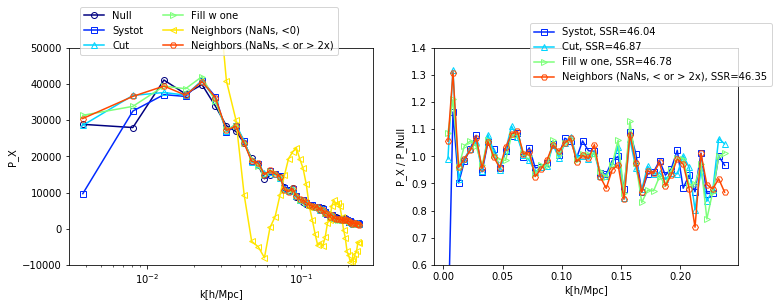

In [97]:
labels = ['Null', 'Systot', 'Cut', 'Fill w one', 'Neighbors (NaNs, <0)', 'Neighbors (NaNs, < or > 2x)']
colors = dict(zip(labels, [plt.cm.jet(i/len(labels)) for i in range(len(labels))]))
markers = dict(zip(labels, ['o', 's', '^', '>', '<', 'H']))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2)


for r_i, n_i in zip([r_null, r_default, r_cut, r_fill, r_master, r_master_n],
                    labels):
    
    ax1.plot(r_i.poles['k'], 
             r_i.poles['power_0'].real-r_i.attrs['shotnoise'],
            label=n_i,
            color=colors[n_i],
            marker=markers[n_i],
            fillstyle='none')
ax1.legend(bbox_to_anchor=(0.1, 1.01, 0.8, 0.2), ncol=2, fontsize=10)
# plt.xscale('log')
ax1.set(ylabel='P_X', xlabel='k[h/Mpc]', xscale='log', ylim=(-1e4, 5e4))


for r_i, n_i in zip([r_default, r_cut, r_fill, r_master_n],
                    ['Systot', 'Cut', 'Fill w one', 'Neighbors (NaNs, < or > 2x)']):
    
    y_i = (r_i.poles['power_0'].real-r_i.attrs['shotnoise'])/(r_null.poles['power_0']-r_null.attrs['shotnoise'])
    ax2.plot(r_i.poles['k'], 
             y_i,
             label=n_i+', SSR=%.2f'%((y_i*y_i).sum()), 
            color=colors[n_i],
            marker=markers[n_i],
            fillstyle='none')

ax2.legend(bbox_to_anchor=(0.3, 0.8, 0.1, 0.1), ncol=1, fontsize=10)
ax2.set(ylim=(0.6, 1.4), ylabel='P_X / P_Null', xlabel='k[h/Mpc]')

[ 003837.76 ]   0: 04-17 14:59  EbossCatalog    INFO     compmin : 0.5
[ 003837.76 ]   0: 04-17 14:59  EbossCatalog    INFO     zmin:0.8, zmax:1.5
[ 003837.77 ]   0: 04-17 14:59  EbossCatalog    INFO     108489 galaxies pass the cuts
[ 003837.77 ]   0: 04-17 14:59  EbossCatalog    INFO     % of galaxies after cut 0.49
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


38 3 0


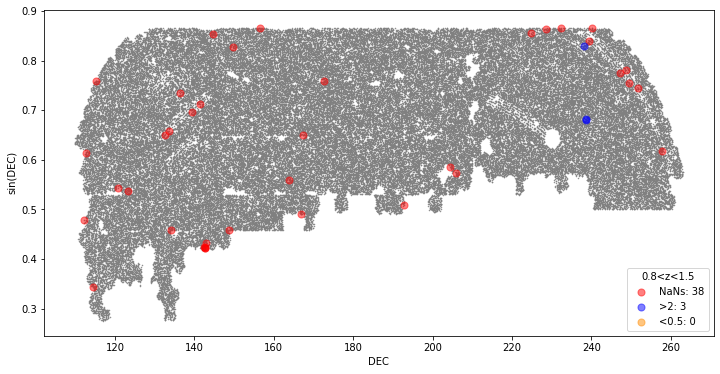

[ 003840.64 ]   0: 04-17 14:59  EbossCatalog    INFO     compmin : 0.5
[ 003840.64 ]   0: 04-17 14:59  EbossCatalog    INFO     zmin:1.5, zmax:2.2
[ 003840.65 ]   0: 04-17 14:59  EbossCatalog    INFO     111061 galaxies pass the cuts
[ 003840.65 ]   0: 04-17 14:59  EbossCatalog    INFO     % of galaxies after cut 0.51


35 0 0


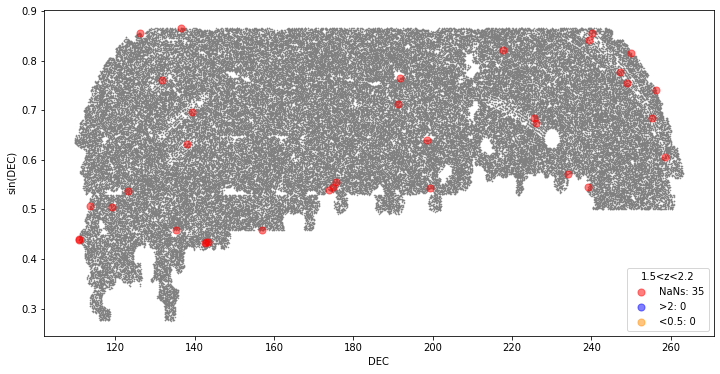

In [112]:
for zslice in ['low', 'high']:
    
    mock = 9
    if zslice == 'low':
        zmin = 0.8
        zmax = 1.5
    else:
        zmin = 1.5
        zmax = 2.2
        
    data = lb.EbossCatalog(f'/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_{mock:04d}.dat.fits', 
                          zmin=zmin, zmax=zmax)    
    mapper = SysWeight(f'/B/Shared/mehdi/eboss/mocks/NGC_{mock:04d}_contaminated/'\
                       f'results/NGC_{zslice}_512/regression/nn_plain/nn-weights.hp512.fits')    
    wsys = mapper(data.data['RA'], data.data['DEC'])

    w_nan = np.isnan(wsys)
    w_high = wsys > 2.
    w_low = wsys < 0.5
    print(w_nan.sum(), w_high.sum(), w_low.sum())

    plt.figure(figsize=(12, 6))

    kw = dict(marker='o', alpha=0.5)

    plt.scatter(data.data['RA'], np.sin(np.deg2rad(data.data['DEC'])), 1, c='grey', marker='.')

    plt.scatter(data.data['RA'][w_nan], np.sin(np.deg2rad(data.data['DEC'][w_nan])), 50, 
                label='NaNs: %d'%w_nan.sum(), **kw, c='r')

    plt.scatter(data.data['RA'][w_high], np.sin(np.deg2rad(data.data['DEC'][w_high])), 50, 
                label='>2: %d'%w_high.sum(), **kw, c='b')

    plt.scatter(data.data['RA'][w_low], np.sin(np.deg2rad(data.data['DEC'][w_low])), 50, 
                label='<0.5: %d'%w_low.sum(), **kw, c='darkorange')

    plt.legend(title='%.1f<z<%.1f'%(zmin, zmax))
    plt.ylabel('sin(DEC)')
    plt.xlabel('DEC')
    plt.show()

In [131]:
zmin = 0.8
zmax = 2.2
data = lb.EbossCatalog(f'/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_{mock:04d}.dat.fits', 
                      zmin=zmin, zmax=zmax)

[ 005932.16 ]   0: 04-17 15:33  EbossCatalog    INFO     compmin : 0.5
[ 005932.16 ]   0: 04-17 15:33  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 005932.17 ]   0: 04-17 15:33  EbossCatalog    INFO     219550 galaxies pass the cuts
[ 005932.17 ]   0: 04-17 15:33  EbossCatalog    INFO     % of galaxies after cut 1.00


In [132]:
path = '/B/Shared/mehdi/eboss/mocks/NGC_0009_contaminated/results/'
zcuts = {
       'low':[[0.8, 1.5], SysWeight(f'{path}NGC_low_512/regression/nn_plain/nn-weights.hp512.fits', fix=False)],
       'high':[[1.5, 2.2], SysWeight(f'{path}NGC_high_512/regression/nn_plain/nn-weights.hp512.fits', fix=False)]
       }
data.swap(zcuts, ['low', 'high'])

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
[ 005933.54 ]   0: 04-17 15:33  EbossCatalog    INFO     slice: low, wsysmin: nan, wsysmax: nan
[ 005933.55 ]   0: 04-17 15:33  EbossCatalog    INFO     number of objs w zcut [0.8, 1.5] : 108489
[ 005933.56 ]   0: 04-17 15:33  EbossCatalog    INFO     slice: high, wsysmin: nan, wsysmax: nan
[ 005933.56 ]   0: 04-17 15:33  EbossCatalog    INFO     number of objs w zcut [1.5, 2.2] : 111061


In [133]:
random = lb.EbossCatalog(f'/B/Shared/eBOSS/contaminated/EZmock_eBOSS_QSO_NGC_v7_{mock:04d}.ran.fits', 
                      zmin=zmin, zmax=zmax)

[ 005938.71 ]   0: 04-17 15:34  EbossCatalog    INFO     compmin : 0.5
[ 005938.71 ]   0: 04-17 15:34  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 005938.82 ]   0: 04-17 15:34  EbossCatalog    INFO     3961799 galaxies pass the cuts
[ 005938.83 ]   0: 04-17 15:34  EbossCatalog    INFO     % of galaxies after cut 1.00


In [134]:
random.tohp(512, raw=False)

[ 005942.76 ]   0: 04-17 15:34  EbossCatalog    INFO     Projecting to HEALPIX as galaxy with 512
[ 005942.76 ]   0: 04-17 15:34  EbossCatalog    INFO     cdata not found
[ 005942.76 ]   0: 04-17 15:34  EbossCatalog    INFO     raw: False


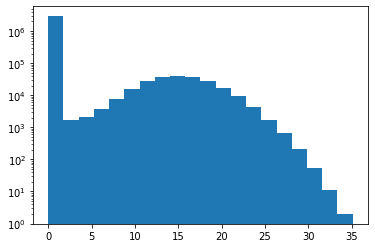

In [135]:
_=plt.hist(random.hpmap, bins=20)
plt.yscale('log')

In [136]:
hpix = lb.radec2hpix(512, random.data['RA'], random.data['DEC']) # HEALPix index from RA and DEC
random_frac = random.hpmap[hpix] 

In [137]:
hpix = lb.radec2hpix(512, data.data['RA'], data.data['DEC']) # HEALPix index from RA and DEC
data_frac = random.hpmap[hpix]

0.0014955327112758624


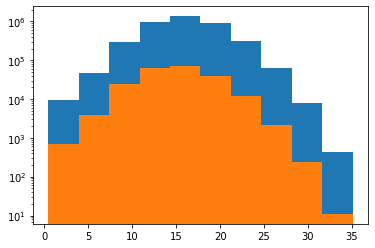

In [138]:
_,b,_= plt.hist(random_frac)
plt.hist(data_frac, bins=b)

print((random_frac < 0.2*random_frac.mean()).mean())
#print((random_frac < 0.2*random_frac.mean()).mean())
_=plt.yscale('log')

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Text(0, 0.5, 'Data w_systot')

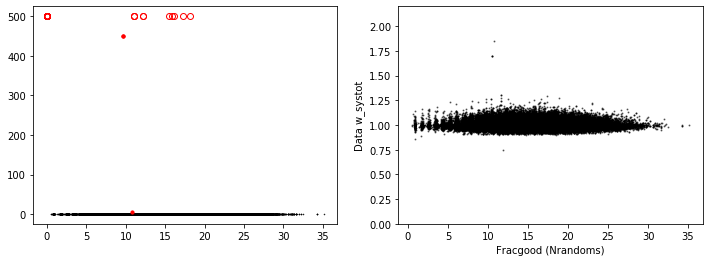

In [151]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

wsys_nan = np.isnan(data.data['WEIGHT_SYSTOT'])
w_high = data.data['WEIGHT_SYSTOT'] > 2.0
ax1.scatter(data_frac[~wsys_nan], data.data['WEIGHT_SYSTOT'][~wsys_nan], 1, marker='.', color='k')
ax1.scatter(data_frac[w_high], data.data['WEIGHT_SYSTOT'][w_high], 
            10, marker='o', color='r')
ax1.plot(data_frac[wsys_nan], 500*np.ones(wsys_nan.sum()), marker='o', 
         color='r', fillstyle='none', ls='none')


wsys_nan = np.isnan(data.data['WEIGHT_SYSTOT'])
ax2.scatter(data_frac[~wsys_nan], data.data['WEIGHT_SYSTOT'][~wsys_nan], 1, marker='o', color='k', alpha=0.5)
# ax2.scatter(data_frac[wsys_nan], 500*np.ones(wsys_nan.sum()), 1, marker='o', color='k')
ax2.set_ylim(0, 2.2)
ax2.set_xlabel('Fracgood (Nrandoms)')
ax2.set_ylabel('Data w_systot')

In [152]:
wsys_nan.sum()

73

In [160]:
nan_ne0frac = (wsys_nan & (data_frac > 0))

In [161]:
hpix_nanfrac = lb.radec2hpix(512, data.data['RA'][nan_ne0frac], data.data['DEC'][nan_ne0frac])

In [156]:
import pandas as pd

In [157]:
df = pd.read_hdf('/home/mehdi/data/templates/SDSS_WISE_HI_imageprop_nside512.h5', 'templates')
df.head()

[ 008932.39 ]   0: 04-17 16:23  numexpr.utils   INFO     Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[ 008932.39 ]   0: 04-17 16:23  numexpr.utils   INFO     NumExpr defaulting to 8 threads.


,nran,sky_g,sky_r,sky_i,sky_z,airmass,ebv,depth_g,depth_r,depth_i,...,psf_r,psf_i,psf_z,w1_med,w1_covmed,w1_moon,star_density,loghi,run,depth_g_minus_ebv
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.321053,53.861678,0.0,0.0,20.802680,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.247458,56.505509,0.0,0.0,20.787574,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.247467,56.505200,0.0,0.0,20.776386,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.321044,53.861987,0.0,0.0,20.788406,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.324270,53.746094,0.0,0.0,20.805544,NaN,NaN


In [162]:
hpix_nanfrac

907051
907051
907051
907050
892716
882295
882295
888623
894763
890669


In [163]:
df.loc[hpix_nanfrac, :]

,nran,sky_g,sky_r,sky_i,sky_z,airmass,ebv,depth_g,depth_r,depth_i,...,psf_r,psf_i,psf_z,w1_med,w1_covmed,w1_moon,star_density,loghi,run,depth_g_minus_ebv
907051,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.856122,23.619141,0.0,13.75,20.378792,NaN,NaN
907051,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.856122,23.619141,0.0,13.75,20.378792,NaN,NaN
907051,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.856122,23.619141,0.0,13.75,20.378792,NaN,NaN
907050,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.856122,23.619141,0.0,11.75,20.366985,NaN,NaN
892716,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.817073,23.592679,0.0,4.50,20.336034,NaN,NaN
882295,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.324893,23.592204,0.0,8.50,20.875475,NaN,NaN
882295,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.324893,23.592204,0.0,8.50,20.875475,NaN,NaN
888623,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.782334,23.625000,0.0,7.50,20.208527,NaN,NaN
894763,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.849511,23.562500,0.0,10.50,20.385404,NaN,NaN
890669,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.782334,23.625000,0.0,4.50,20.314742,NaN,NaN


In [164]:
data.orgcol[nan_ne0frac]

-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30
-4.322638110272998e-30


In [167]:
(data.orgcol < 0).sum()

11

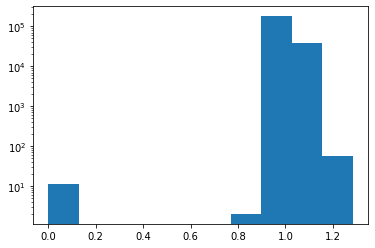

In [166]:
plt.hist(data.orgcol)
plt.yscale('log')

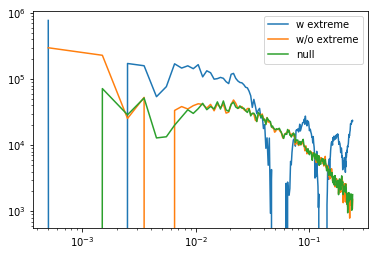

In [31]:
for pki, label in zip([pk, pk_fix, pk_null], ['w extreme', 'w/o extreme', 'null']):
    plt.loglog(pki[0][:,0], pki[0][:, 2]-pki[1], label=label)
plt.legend()